# CNN and Conditional Random Field joint training for Ice Floe Segmentation

#### ConvCRF module Source https://github.com/MarvinTeichmann/ConvCRF

In [1]:
import os,sys,inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
sys.path.insert(0,parentdir + '/ConvCRF')

In [2]:
import torchvision
torchvision.__version__

'0.4.2'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torchsummary import summary

from torchvision import transforms, utils, models
import torchvision.transforms.functional as TF

import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import os
import imageio

from PIL import Image

import cv2

In [4]:
from convcrf import convcrf

from model.architecture import ResUNet, UNet, AttnResUNet2

from tools.dataloader import DatasetFloe, DatasetFloeVal  # Init signature: DatasetFloe(patch_size: int, batch_size: int, mode='train')
from tools.loss import calc_loss          # smoothening factor for dice loss is 1e-6
from tools.crf_conf import default_conf   # configuration for conditional random field. 
from tools.metrics import count_parameters

In [54]:
basic_model = ResUNet(list(models.resnet34().children()), 2)

In [55]:
basic_model

ResUNet(
  (layer_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer_1): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [57]:
summary(basic_model, (3,480,480), device= 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 480, 480]           1,792
       BatchNorm2d-2         [-1, 64, 480, 480]             128
              ReLU-3         [-1, 64, 480, 480]               0
            Conv2d-4         [-1, 64, 480, 480]          36,928
       BatchNorm2d-5         [-1, 64, 480, 480]             128
              ReLU-6         [-1, 64, 480, 480]               0
            Conv2d-7         [-1, 64, 240, 240]           9,408
       BatchNorm2d-8         [-1, 64, 240, 240]             128
              ReLU-9         [-1, 64, 240, 240]               0
        MaxPool2d-10         [-1, 64, 120, 120]               0
           Conv2d-11         [-1, 64, 120, 120]          36,864
      BatchNorm2d-12         [-1, 64, 120, 120]             128
             ReLU-13         [-1, 64, 120, 120]               0
           Conv2d-14         [-1, 64, 1

In [22]:
model3 = models.resnet34()

In [23]:
layers = list(model3.children())

In [26]:
layers[:1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)]

In [28]:
layers[1:2]

[BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

In [29]:
layers[2:3]

[ReLU(inplace=True)]

In [24]:
layers[:3]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True)]

In [25]:
len(layers)

10

In [33]:
upto_3 = nn.Sequential(*layers[:3])
summary(upto_3, (3, 480,480), device = 'cpu')
print(upto_3(torch.randn(1,3,480,480)).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           9,408
       BatchNorm2d-2         [-1, 64, 240, 240]             128
              ReLU-3         [-1, 64, 240, 240]               0
Total params: 9,536
Trainable params: 9,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.64
Forward/backward pass size (MB): 84.38
Params size (MB): 0.04
Estimated Total Size (MB): 87.05
----------------------------------------------------------------
torch.Size([1, 64, 240, 240])


In [44]:
upto_5 = nn.Sequential(*layers[3:5])
summary(upto_5, (64, 240, 240), device = 'cpu')
print(upto_(torch.randn(1,64,240,240)).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1         [-1, 64, 120, 120]               0
            Conv2d-2         [-1, 64, 120, 120]          36,864
       BatchNorm2d-3         [-1, 64, 120, 120]             128
              ReLU-4         [-1, 64, 120, 120]               0
            Conv2d-5         [-1, 64, 120, 120]          36,864
       BatchNorm2d-6         [-1, 64, 120, 120]             128
              ReLU-7         [-1, 64, 120, 120]               0
        BasicBlock-8         [-1, 64, 120, 120]               0
            Conv2d-9         [-1, 64, 120, 120]          36,864
      BatchNorm2d-10         [-1, 64, 120, 120]             128
             ReLU-11         [-1, 64, 120, 120]               0
           Conv2d-12         [-1, 64, 120, 120]          36,864
      BatchNorm2d-13         [-1, 64, 120, 120]             128
             ReLU-14         [-1, 64, 1

In [45]:
upto_6 = nn.Sequential(*layers[5])
summary(upto_6, (64, 120, 120), device = 'cpu')
print(upto_6(torch.randn(1,64,120,120)).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 60]          73,728
       BatchNorm2d-2          [-1, 128, 60, 60]             256
              ReLU-3          [-1, 128, 60, 60]               0
            Conv2d-4          [-1, 128, 60, 60]         147,456
       BatchNorm2d-5          [-1, 128, 60, 60]             256
            Conv2d-6          [-1, 128, 60, 60]           8,192
       BatchNorm2d-7          [-1, 128, 60, 60]             256
              ReLU-8          [-1, 128, 60, 60]               0
        BasicBlock-9          [-1, 128, 60, 60]               0
           Conv2d-10          [-1, 128, 60, 60]         147,456
      BatchNorm2d-11          [-1, 128, 60, 60]             256
             ReLU-12          [-1, 128, 60, 60]               0
           Conv2d-13          [-1, 128, 60, 60]         147,456
      BatchNorm2d-14          [-1, 128,

In [51]:
upto_7 = nn.Sequential(*layers[6])
summary(upto_7, (128, 60, 60), device = 'cpu')
print(upto_7(torch.randn(1,128,60,60)).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 30, 30]         294,912
       BatchNorm2d-2          [-1, 256, 30, 30]             512
              ReLU-3          [-1, 256, 30, 30]               0
            Conv2d-4          [-1, 256, 30, 30]         589,824
       BatchNorm2d-5          [-1, 256, 30, 30]             512
            Conv2d-6          [-1, 256, 30, 30]          32,768
       BatchNorm2d-7          [-1, 256, 30, 30]             512
              ReLU-8          [-1, 256, 30, 30]               0
        BasicBlock-9          [-1, 256, 30, 30]               0
           Conv2d-10          [-1, 256, 30, 30]         589,824
      BatchNorm2d-11          [-1, 256, 30, 30]             512
             ReLU-12          [-1, 256, 30, 30]               0
           Conv2d-13          [-1, 256, 30, 30]         589,824
      BatchNorm2d-14          [-1, 256,

In [52]:
upto_8 = nn.Sequential(*layers[7])
summary(upto_8, (256, 30, 30), device = 'cpu')
print(upto_8(torch.randn(1,256,30,30)).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 15, 15]       1,179,648
       BatchNorm2d-2          [-1, 512, 15, 15]           1,024
              ReLU-3          [-1, 512, 15, 15]               0
            Conv2d-4          [-1, 512, 15, 15]       2,359,296
       BatchNorm2d-5          [-1, 512, 15, 15]           1,024
            Conv2d-6          [-1, 512, 15, 15]         131,072
       BatchNorm2d-7          [-1, 512, 15, 15]           1,024
              ReLU-8          [-1, 512, 15, 15]               0
        BasicBlock-9          [-1, 512, 15, 15]               0
           Conv2d-10          [-1, 512, 15, 15]       2,359,296
      BatchNorm2d-11          [-1, 512, 15, 15]           1,024
             ReLU-12          [-1, 512, 15, 15]               0
           Conv2d-13          [-1, 512, 15, 15]       2,359,296
      BatchNorm2d-14          [-1, 512,

In [5]:
batch_size = 1

train_ds = DatasetFloe(patch_size= 480, batch_size= batch_size, mode='train')
train_loader =  DataLoader(train_ds, batch_size=batch_size, num_workers=0)

val_ds = DatasetFloeVal(patch_size= 480,)  # ADDED LATER
val_loader =  DataLoader(val_ds, batch_size=1, num_workers=0)  # ADDED LATER

In [6]:
default_conf['filter_size'] = 1
default_conf['blur'] = 0
default_conf['trainable'] = True
default_conf['trainable_bias'] = True

In [7]:
from backboned_unet import Unet
# 'resnet'- 18, 34, 50, 101, 152
# 'vgg'- 16, 19
# 'densenet' - 121, 161, 169, 201

model1 = Unet(backbone_name='resnet34', classes=2)

upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


In [7]:
resnet = models.resnet34(pretrained=False)
layers = list(resnet.children())
model1 = AttnResUNet2(layers, 2)

In [11]:
# """ DLV3 RESNET101"""
# from torchvision.models.segmentation.deeplabv3 import DeepLabHead
# model1 = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model1.classifier = DeepLabHead(2048, 1)

In [8]:
from model.arch2 import R2AttU_Net

In [9]:
model1 = R2AttU_Net(3, 2)

In [7]:
### LOAD PRESAVED MODEL FOR FINETUNING?
model1 = torch.load('/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/2_480_model1RESUNET_1500iter_NEW_DATA.mdl')

In [13]:
n_iterations = 15000
learning_rate = 1e-4
weight_bce = 0.5
# loss_weight = torch.tensor([0.5]).requires_grad_() # Make the weight_bce trainable as well. Didn't seem to work.

# model1 = ResUNet(layers, 2)
model2 = convcrf.GaussCRF(conf=default_conf, shape=(480,480), nclasses=2)

params = list(model1.parameters()) + list(model2.parameters())

optimizer = torch.optim.Adam(
    params, 
    lr= learning_rate)#,
#         weight_decay = weight_decay)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[2000],  
    gamma = 0.1
)

writer = SummaryWriter()

In [14]:
def model_train(model1, model2, train_loader, learning_rate, weight_bce):
    model1.cuda()
    model1.train()
    
    total_iters = 0
    
    for i in range(n_iterations):
        for batch_idx, sample in enumerate(train_loader):
            
            model1.train()
            
            X = sample['image'].cuda()
            y = sample['mask'].cuda()
            
            optimizer.zero_grad()
            
            pred1 = model1(X)    # USE pred['out'] for dlv3 and fcn
            
            if (pred1.shape[1] == 2):
                loss = calc_loss(pred1, y, weight_bce=weight_bce)
            else:
                loss = calc_loss(pred1['out'], y[:,1,:,:].unsqueeze(1), weight_bce=weight_bce)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_iters +=1
            
            print("Iteration: {}\tCurrent loss:{:.6f}".format(total_iters, loss.item()))
            
            writer.add_scalar('training', loss.item(), total_iters)
            writer.add_image('mask', y[:,1,:,:].unsqueeze(1), total_iters, dataformats='NCHW')
            if (pred1.shape[1] == 2):
                writer.add_image('prediction', torch.sigmoid(pred1)[:,1,:,:].unsqueeze(1), total_iters, dataformats='NCHW')
            else:
                writer.add_image('prediction', torch.sigmoid(pred1['out'])[:,0,:,:].unsqueeze(1), total_iters, dataformats='NCHW')
            
            if(total_iters % 200 == 0):
                model1.eval()
                val_loss_total = []
                with torch.no_grad():
                    for _, sample_val in enumerate(val_loader):
                        
                        X_val = sample_val['image'].cuda()
                        y_val = sample_val['mask'].cuda()
                        pred1_val = model1(X_val)    # USE pred['out'] for dlv3 and fcn
            
                        if (pred1_val.shape[1] == 2):
                            loss_val = calc_loss(pred1_val, y_val, weight_bce=weight_bce)
                        else:
                            loss_val = calc_loss(pred1['out'], y_val[:,1,:,:].unsqueeze(1), weight_bce=weight_bce)
                        
                        val_loss_total.append(loss_val.item())
                        
                writer.add_scalar('validation', np.mean(val_loss_total), total_iters)
                print("Validation loss:{:.6f}".format(np.mean(val_loss_total)))
                
            writer.close()

In [15]:
model_train(model1, model2, train_loader, learning_rate, weight_bce)

Iteration: 1	Current loss:0.167682
Iteration: 2	Current loss:0.083197
Iteration: 3	Current loss:0.106085
Iteration: 4	Current loss:0.231220
Iteration: 5	Current loss:0.251718
Iteration: 6	Current loss:0.071169
Iteration: 7	Current loss:0.075169
Iteration: 8	Current loss:0.252340
Iteration: 9	Current loss:0.251277
Iteration: 10	Current loss:0.159271
Iteration: 11	Current loss:0.251856
Iteration: 12	Current loss:0.167344
Iteration: 13	Current loss:0.251859
Iteration: 14	Current loss:0.266856
Iteration: 15	Current loss:0.156967
Iteration: 16	Current loss:0.253963
Iteration: 17	Current loss:0.137887
Iteration: 18	Current loss:0.266422
Iteration: 19	Current loss:0.147531
Iteration: 20	Current loss:0.250796
Iteration: 21	Current loss:0.196469
Iteration: 22	Current loss:0.194217
Iteration: 23	Current loss:0.188455
Iteration: 24	Current loss:0.251252
Iteration: 25	Current loss:0.250269
Iteration: 26	Current loss:0.255591
Iteration: 27	Current loss:0.182555
Iteration: 28	Current loss:0.423316
I

In [ ]:
def ft_model(model1, model2, train_loader, learning_rate, weight_bce):
    model1.cuda()
#     model1.train()
    model2.cuda()
#     model2.train()
    total_iters = 0
    
    for i in range(n_iterations):
        for batch_idx, sample in enumerate(train_loader):
            model1.train()
            model2.train()
            
            X = sample['image'].cuda()
            y = sample['mask'].cuda()
            
            optimizer.zero_grad()
            
            pred1 = model1(X)    # USE pred['out'] for dlv3 and fcn
            pred2 = model2(unary=torch.sigmoid(pred1), img=X)
            loss = calc_loss(pred2, y, weight_bce=weight_bce)

            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_iters +=1
            
            print("Iteration: {}\tCurrent loss:{:.6f}".format(total_iters,loss.item()))
            
            writer.add_scalar('training', loss.item(), total_iters)
            writer.add_image('mask', y[:,1,:,:].unsqueeze(1), total_iters, dataformats='NCHW')
            writer.add_image('prediction', torch.sigmoid(pred2)[:,1,:,:].unsqueeze(1), total_iters, dataformats='NCHW')
#             writer.close()
            
            if(total_iters % 2000 == 0):
                model1.eval()
                val_loss_total = []
                with torch.no_grad():
                    for _, sample_val in enumerate(val_loader):
                        
                        X_val = sample_val['image'].cuda()
                        y_val = sample_val['mask'].cuda()
                        pred1_val = model1(X_val)    # USE pred['out'] for dlv3 and fcn
                        pred2_val = model2(unary=pred1_val, img=X_val)
            
                        loss_val = calc_loss(pred2_val, y_val, weight_bce=weight_bce)
                        val_loss_total.append(loss_val.item())
                        
                writer.add_scalar('validation', np.mean(val_loss_total), total_iters)
                print("Validation loss:{:.6f}".format(np.mean(val_loss_total)))
            writer.close()

In [10]:
ft_model(model1, model2, train_loader, learning_rate, weight_bce)

Iteration: 1	Current loss:0.233593
Iteration: 2	Current loss:0.233495
Iteration: 3	Current loss:0.232781
Iteration: 4	Current loss:0.238371
Iteration: 5	Current loss:0.238776
Iteration: 6	Current loss:0.233472
Iteration: 7	Current loss:0.235752
Iteration: 8	Current loss:0.229504
Iteration: 9	Current loss:0.236166
Iteration: 10	Current loss:0.236820
Iteration: 11	Current loss:0.229684
Iteration: 12	Current loss:0.235985
Iteration: 13	Current loss:0.232690
Iteration: 14	Current loss:0.230701
Iteration: 15	Current loss:0.243248
Iteration: 16	Current loss:0.229438
Iteration: 17	Current loss:0.243290
Iteration: 18	Current loss:0.230614
Iteration: 19	Current loss:0.235669
Iteration: 20	Current loss:0.241969
Iteration: 21	Current loss:0.223643
Iteration: 22	Current loss:0.246130
Iteration: 23	Current loss:0.227829
Iteration: 24	Current loss:0.247747
Iteration: 25	Current loss:0.245148
Iteration: 26	Current loss:0.241428
Iteration: 27	Current loss:0.228998
Iteration: 28	Current loss:0.230548
I

In [11]:
pred1 = model1(torch.randn(1,3,480,480).cuda())

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 11.91 GiB total capacity; 9.09 GiB already allocated; 51.25 MiB free; 209.59 MiB cached)

In [12]:
type(pred1[0,0,0,0])

NameError: name 'pred1' is not defined

In [23]:
unary = torch.sigmoid(pred1)>0.5

In [10]:
unary.int()

NameError: name 'unary' is not defined

In [ ]:
a

In [11]:
model1.eval()
model2.eval()

for param in list(model2.parameters()):
    param.requires_grad = False
    
# Your choice, save state_dict or model strait away. Saving the model straight away may break it after some refactoring. 

In [16]:
torch.save(model1, '../model/weights/UNET_CRF/NEW/attnResunet_15000_model1.mdl')

/home/muzik999/.conda/envs/pytorch_gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type R2AttU_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/muzik999/.conda/envs/pytorch_gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/muzik999/.conda/envs/pytorch_gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Upsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/muzik999/.conda/envs/pytorch_gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RRCNN_block. It won't

In [17]:
torch.save(model2, '/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/attnResunet_15000_model2.mdl')

/home/muzik999/.conda/envs/pytorch_gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GaussCRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/muzik999/.conda/envs/pytorch_gpu/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvCRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
list(model2.parameters())

[Parameter containing:
 tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
          [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
          ...,
          [285., 285., 285.,  ..., 285., 285., 285.],
          [286., 286., 286.,  ..., 286., 286., 286.],
          [287., 287., 287.,  ..., 287., 287., 287.]],
 
         [[  0.,   1.,   2.,  ..., 285., 286., 287.],
          [  0.,   1.,   2.,  ..., 285., 286., 287.],
          [  0.,   1.,   2.,  ..., 285., 286., 287.],
          ...,
          [  0.,   1.,   2.,  ..., 285., 286., 287.],
          [  0.,   1.,   2.,  ..., 285., 286., 287.],
          [  0.,   1.,   2.,  ..., 285., 286., 287.]]], device='cuda:0'),
 Parameter containing:
 tensor([0.3333], device='cuda:0'),
 Parameter containing:
 tensor([0.0769], device='cuda:0'),
 Parameter containing:
 tensor([10.0457], device='cuda:0'),
 Parameter containing:
 tensor([3.0457], device='cuda:0'),
 Parameter containing:
 tensor([[[[0.24

In [28]:
torch.save(default_conf, '../model/weights/UNET_CRF/9_config.json')

## Some visualization stuff. 

In [24]:
batch_idx, sample = next(enumerate(train_loader))

X = sample['image'].cuda()
y = sample['mask'].cuda()

optimizer.zero_grad()

pred1 = model1(X)    # USE pred['out'] for dlv3 and fcn
pred2 = model2.forward(unary=pred1, img=X)
loss = calc_loss(pred1,y, weight_bce=weight_bce)

print("Iteration: {}\tCurrent loss:{:.6f}".format(1,loss.item()))

Iteration: 1	Current loss:0.276136


In [84]:
n=7

Text(0.5, 1.0, 'Prediction from CRF')

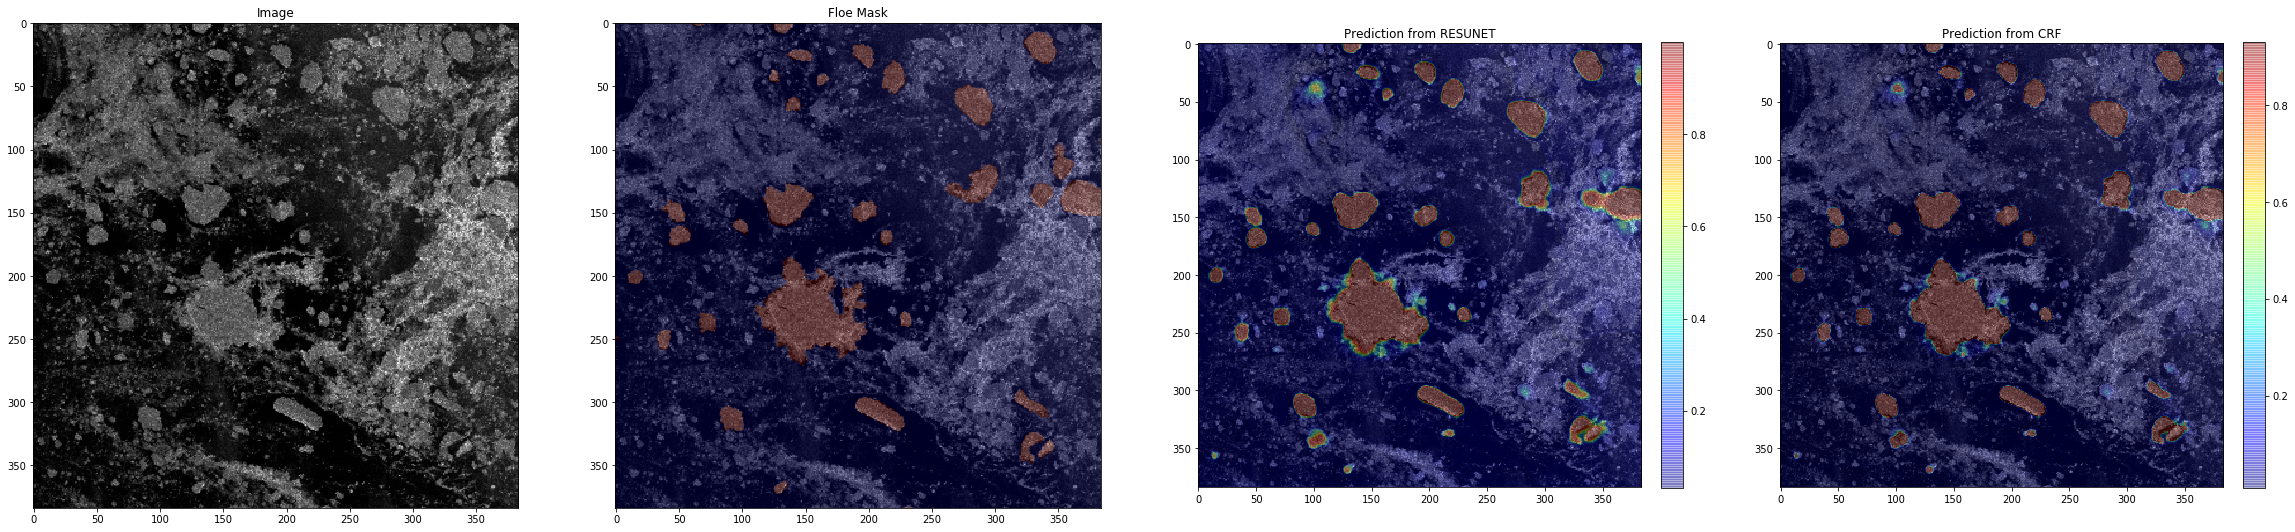

In [85]:
plt.figure(figsize=(40,40))
plt.title('UNET-CRF are jointly trained from scratch')

plt.subplot(141)
plt.imshow(X[n,0,:,:].cpu(), cmap='gray')
plt.title('Image')

plt.subplot(142)
plt.imshow(X[n,0,:,:].cpu(), cmap='gray')
plt.imshow(y[n,1,:,:].cpu(), cmap='jet', alpha=0.3)
plt.title('Floe Mask')


plt.subplot(143)
plt.imshow(X[n,0,:,:].cpu(), cmap='gray')
plt.imshow(torch.sigmoid(pred1.data.cpu())[n,1,:,:], cmap='jet', alpha=0.3)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Prediction from RESUNET')

plt.subplot(144)
plt.imshow(X[n,0,:,:].cpu(), cmap='gray')
plt.imshow(torch.sigmoid(pred2.data.cpu())[n,1,:,:], cmap='jet', alpha=0.3)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Prediction from CRF')

# plt.savefig('../model/weights/UNET_CRF/9_plot_RESUNET-CRF(FullTrain)_training6.png')